<h1> Telescope Diffraction Limit </h1>
<p> Calculating the diffraction pattern due to the finite aperture of a telescope</p>
<h5>Point Spred Function is the squared amplitude of the Fourier transform of the complex pupil function:</h5>

$P(x,y) = P_r (x,y) e^{\frac{-i 2 \pi W}{\lambda}}$

<h5> Or more specifically: </h5>

$ PSF (x_f, y_f) = FT [P(x,y)] \left( k_x = \frac{x_f}{\lambda f} , k_y = \frac{y_f}{\lambda f} \right)$

$\frac{\Delta x}{\Delta \theta} = f$
<h5> In the simplest case:</h5>

$P(r, \theta)$ is just 1 within some radius $D/2$, and 0 outside. The image formed in this case is:

$I = C \left( \frac{J_1 (\pi r_f)}{\pi r_f} \right)^2$

I think it should be this:

$I = C \left( \frac{J_1 (\pi r_f  r)}{\pi r_f  r} \right)^2$

Where $J_1$ is the first-order Bessel function, $r_f = D \theta / \lambda$
<h2> Importing Libraries</h2>

![Alt text](image.png)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as integrate

In [2]:
def J_1_numpy(input_x):
    a = 0
    b = np.pi
    N = 256
    x = np.linspace(a,b,N)
    y = (1/np.pi)*np.cos(x - input_x*np.sin(x))
    return integrate.simpson(y,x)

/tmp/ipykernel_13511/58991933.py:27: RuntimeWarning: invalid value encountered in divide
  airy_disk = (1.0 / np.pi) * ( np.absolute(bessel_component/ (rf * r)) )**2


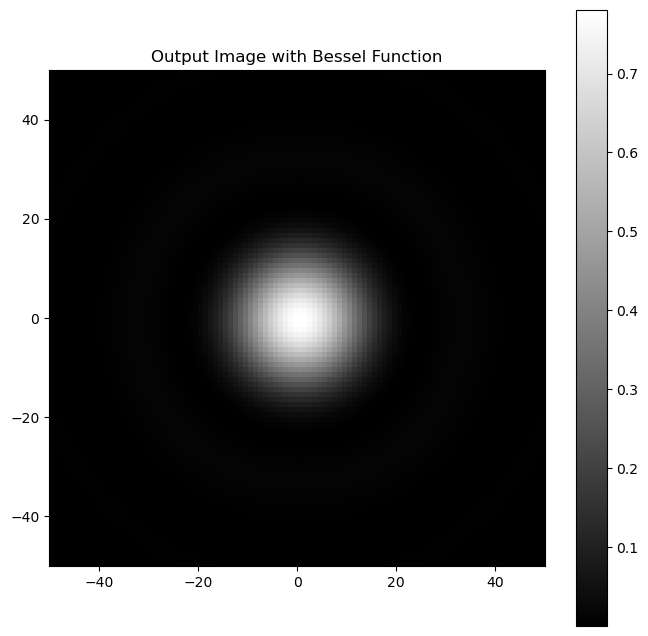

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import j1  # Import Bessel function J_1 I couldn't get my function to work but the j1 function from scipy works

# Define parameters
image_size = 100  # Increase image size for better accuracy
wavelength = 2
pixel_size = 1.0
D = 1.0
theta = 0.1  # Example angular size in radians

# Calculate rf using the formula: rf = D * theta / wavelength
rf = D * theta / wavelength

# Create a coordinate grid for the PSF with increased size
x = np.linspace(-image_size // 2, image_size // 2 - 1, image_size)
y = np.linspace(-image_size // 2, image_size // 2 - 1, image_size)
x, y = np.meshgrid(x, y)

# Calculate the radial distance r from the center
r = np.sqrt(x**2 + y**2)

# Calculate the Bessel function component in 2D
bessel_component = j1(np.pi * rf * r)

# Calculate the Image using the Airy disk formula with the Bessel component
airy_disk = (1.0 / np.pi) * ( np.absolute(bessel_component/ (rf * r)) )**2

# Plot the normalized PSF on a logarithmic scale
plt.figure(figsize=(8, 8))
plt.imshow(airy_disk, cmap='gray', extent=[-image_size//2, image_size//2, -image_size//2, image_size//2])
plt.title('Output Image with Bessel Function')
plt.colorbar(label='')
plt.show()

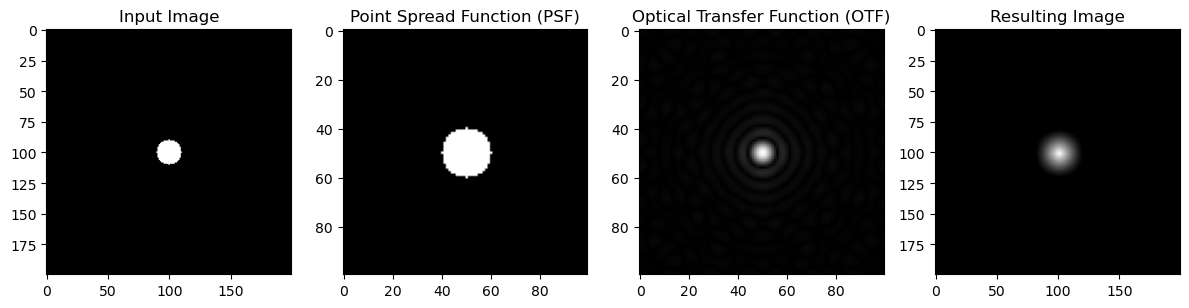

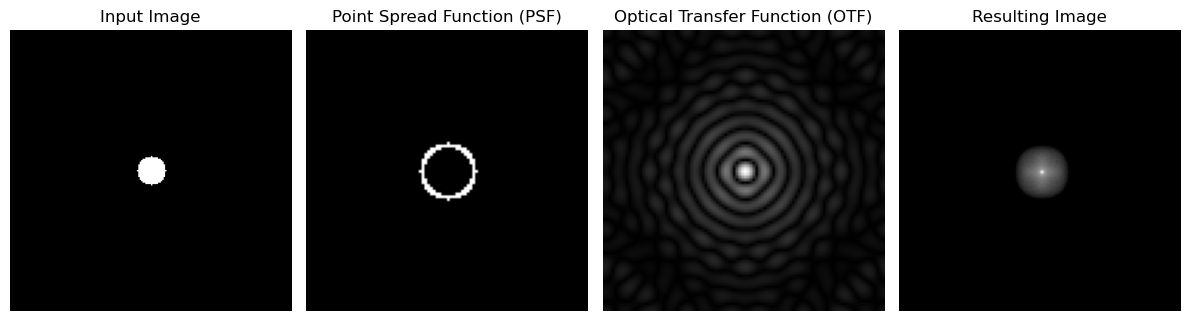

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve

# Define the size of the image and circle parameters
image_size = 200  # Adjust as needed
circle_radius = 10

# Create a dark circle input
input_image = np.zeros((image_size, image_size))
circle_center = (image_size // 2, image_size // 2)
for i in range(image_size):
    for j in range(image_size):
        if (i - circle_center[0])**2 + (j - circle_center[1])**2 <= circle_radius**2:
            input_image[i, j] = 1

# # Define the PSF (assuming a simple circular aperture)
# def generate_psf(size, radius):
#     psf = np.zeros((size, size))
#     center = (size // 2, size // 2)
#     for i in range(size):
#         for j in range(size):
#             distance = np.sqrt((i - center[0])**2 + (j - center[1])**2)
#             if distance <= radius:
#                 psf[i, j] = 1 / np.pi / radius**2  # Normalize to integrate to 1
#     return psf

def generate_psf(size, radius):
    # Create a grid of coordinates
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    center = (size // 2, size // 2)
    
    # Calculate the distance from each point to the center
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    # Create the PSF as a boolean mask and normalize
    psf = (distance <= radius).astype(float) / (np.pi * radius**2)
    
    return psf

def generate_psf_cassegian(size, outer_radius, inner_radius):
    # Create a grid of coordinates
    x, y = np.meshgrid(np.arange(size), np.arange(size))
    center = (size // 2, size // 2)
    
    # Calculate the distance from each point to the center
    distance = np.sqrt((x - center[0])**2 + (y - center[1])**2)
    
    # Create the PSF as a boolean mask with two circles (inner and outer) and normalize
    inner_circle = (distance <= inner_radius).astype(float)
    outer_circle = (distance <= outer_radius).astype(float)
    psf = (outer_circle - inner_circle) / (np.pi * (outer_radius**2 - inner_radius**2))
    
    return psf


# Generate the PSF
psf = generate_psf(image_size*0.5, circle_radius)

# Compute the OTF (Optical Transfer Function) using the Fourier Transform of the PSF
otf = np.fft.fftshift(np.fft.fft2(psf))

# Convolve the input image with the PSF using FFT convolution
output_image = fftconvolve(input_image, psf, mode='same')

# Generate the PSF Cassegian
psf_cassegian = generate_psf_cassegian(image_size*0.5, circle_radius, circle_radius/1.2)

# Compute the OTF (Optical Transfer Function) using the Fourier Transform of the PSF
otf_cassegian = np.fft.fftshift(np.fft.fft2(psf_cassegian))

# Convolve the input image with the PSF using FFT convolution
output_image_cassegian = fftconvolve(input_image, psf_cassegian, mode='same')

# Plot the input image, PSF, OTF, and output image
plt.figure(figsize=(12, 4))
plt.subplot(141)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')

# Plot All simple circle
plt.subplot(142)
plt.imshow(psf, cmap='gray')
plt.title('Point Spread Function (PSF)')

plt.subplot(143)
plt.imshow(np.abs(otf), cmap='gray')
plt.title('Optical Transfer Function (OTF)')

plt.subplot(144)
plt.imshow(output_image, cmap='gray')
plt.title('Resulting Image')

plt.tight_layout()
plt.show()

#_____________________Cassegian_______________

# Plot the input image, PSF, OTF, and output image
plt.figure(figsize=(12, 4))
plt.subplot(141)
plt.imshow(input_image, cmap='gray')
plt.title('Input Image')
plt.axis('off')

# Plot All cassegian
plt.subplot(142)
plt.imshow(psf_cassegian, cmap='gray')
plt.title('Point Spread Function (PSF)')
plt.axis('off')

plt.subplot(143)
plt.imshow(np.abs(otf_cassegian), cmap='gray')
plt.title('Optical Transfer Function (OTF)')
plt.axis('off')

plt.subplot(144)
plt.imshow(output_image_cassegian, cmap='gray')
plt.title('Resulting Image')
plt.axis('off')

plt.tight_layout()
plt.show()